In [1]:
import matplotlib.pyplot as plt
import wntr
import wntr.network.controls as controls
import sqlite3
import csv
import time
import pandas as pd
from platform import python_version

In [2]:
def get_node_list_by_type(list, type):
    result = []
    for node in list:
        if wn.get_node(node).node_type == type:
            result.append(str(node))
    return result

def get_link_list_by_type(list, type):
    result = []
    for link in list:
        if wn.get_link(link).link_type == type:
            result.append(str(link))
    return result

def create_node_header(list):
    result = []
    for node in list:
        result.append(node+"_LEVEL")
    return result

def create_link_header(list):
    result = []
    for link in list:
        result.append(link+"_FLOW")
        result.append(link+"_STATUS")
    return result

def get_controls(list):
    result = []
    for control in list:
        result.append(wn.get_control(control))
    return result

def create_control_dict(actuator):
    dummy_condition = controls.ValueCondition(wn.get_node('T1'), 'level', '>=', 0)
    act_dict = dict.fromkeys(['actuator', 'parameter', 'value', 'condition', 'name'])
    act_dict['actuator'] = wn.get_link(actuator)
    act_dict['parameter'] = 'status'
    act_dict['condition'] = dummy_condition
    act_dict['name'] = actuator
    if type(wn.get_link(actuator).status) is int:
        act_dict['value'] = act_dict['actuator'].status
    else:
        act_dict['value'] = act_dict['actuator'].status.value
    return act_dict
    
def register_results(results):
    values_list = []
    values_list.extend([results.timestamp])

    # Results are divided into: nodes: reservoir and tanks, links: flows and status
    # Get tanks levels
    for tank in tank_list:
        values_list.extend([wn.get_node(tank).level])

    # Get junction  levels
    # for junction in junction_list:
    # values_list.extend([wn.get_node(junction).head - wn.get_node(junction).elevation])

    # Get pumps flows and status
    for pump in pump_list:

        values_list.extend([wn.get_link(pump).flow])

        if type(wn.get_link(pump).status) is int:
            values_list.extend([wn.get_link(pump).status])
        else:
            values_list.extend([wn.get_link(pump).status.value])

    # Get valves flows and status
    for valve in valve_list:
        values_list.extend([wn.get_link(valve).flow])

        if type(wn.get_link(valve).status) is int:
            values_list.extend([wn.get_link(valve).status])
        else:
            values_list.extend([wn.get_link(valve).status.value])

    return values_list

def update_controls():
    for control in control_list:
        update_control(control)

def update_control(control):
    act_name = '\'' + control['name'] + '\''
    rows_1 = c.execute('SELECT value FROM ctown WHERE name = ' + act_name).fetchall()
    conn.commit()
    new_status = int(rows_1[0][0])

    control['value'] = new_status

    #act1 = controls.ControlAction(pump1, 'status', int(pump1_status))
    new_action  = controls.ControlAction(control['actuator'], control['parameter'], control['value'])

    #pump1_control = controls.Control(condition, act1, name='pump1control')
    new_control = controls.Control(control['condition'], new_action, name=control['name'])

    wn.remove_control(control['name'])
    wn.add_control(control['name'], new_control)

In [3]:
# Create the network
inp_file = 'wadi_map.inp'
#inp_file = 'wadi_with_controls.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

node_list = list(wn.node_name_list)
link_list = list(wn.link_name_list)

tank_list = get_node_list_by_type(node_list, 'Tank')
junction_list = get_node_list_by_type(node_list, 'Junction')
pump_list = get_link_list_by_type(link_list, 'Pump')
valve_list = get_link_list_by_type(link_list, 'Valve')

In [4]:
junction_nodes = []
for junction in junction_list:
    junction_nodes.append(wn.get_node(junction))

In [5]:
list_header = ["Timestamps"]
aux = create_node_header(tank_list)
list_header.extend(aux)

#aux = create_node_header(junction_list)
#list_header.extend(aux)

aux = create_link_header(pump_list)
list_header.extend(aux)
list_header.extend(aux)

aux = create_link_header(valve_list)
list_header.extend(aux)

results_list = []
results_list.append(list_header)

In [6]:
# START STEP BY STEP SIMULATION
sim = wntr.sim.EpanetSimulator(wn)
iteration = 0
wn.options.time.duration = 1
iteration_limit = (14*60)/5
while iteration <= iteration_limit:    
    results = sim.run_sim()
    values_list = register_results(results)
    results_list.append(values_list)    
    iteration += 1

In [7]:
with open('wadi_get_node_results_epanet.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

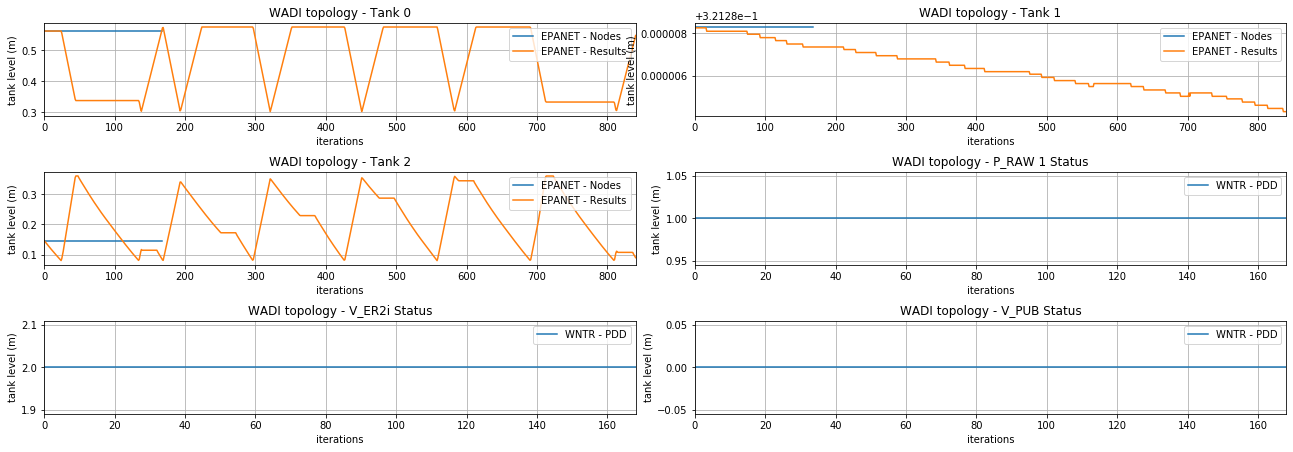

In [8]:
no_minicps_wadi = pd.read_csv('wadi_get_node_results_epanet.csv')
results_minicps_wadi = pd.read_csv('wadi_get_results_results_epanet.csv')

subplot_hspace = 0.6
subplot_wspace = 0.1

dd = plt.subplot(4,2,1)
no_minicps_wadi["T0_LEVEL"].plot(label='EPANET - Nodes', ax=dd)
results_minicps_wadi["T0"].plot(label='EPANET - Results', ax=dd)
plt.title("WADI topology - Tank 0")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,2)
no_minicps_wadi["T1_LEVEL"].plot(label='EPANET - Nodes', ax=dd)
results_minicps_wadi["T1"].plot(label='EPANET - Results', ax=dd)
plt.title("WADI topology - Tank 1")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,3)
no_minicps_wadi["T2_LEVEL"].plot(label='EPANET - Nodes', ax=dd)
results_minicps_wadi["T2"].plot(label='EPANET - Results', ax=dd)
plt.title("WADI topology - Tank 2")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,4)
no_minicps_wadi["P_RAW1_STATUS"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - P_RAW 1 Status")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,5)
no_minicps_wadi["V_ER2i_STATUS"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - V_ER2i Status")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,6)
no_minicps_wadi["V_PUB_STATUS"].plot(label='WNTR - PDD', ax=dd)
plt.title("WADI topology - V_PUB Status")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

In [13]:
results.node['pressure']

name,J_CT3,J_CT6,J_CT5,J2a_15,J1_70,J1_40,J1_50,J1_51,J1_60,J1_61,...,J2b_20,J2b_51,J2b_52,J2a_11,J1_32,SWaT,PUB,T1,T2,T0
0,0.244105,0.244105,0.243676,1.714496,0.934496,1.592929,1.592929,0.934496,1.592929,0.934496,...,1.432974,1.524105,1.524105,1.634496,1.642929,7.629394e-08,3.814697e-08,0.321288,0.146614,0.562929
60,0.241200,0.241200,0.240773,1.418371,0.638371,1.592929,1.592929,0.638371,1.592929,0.638371,...,1.430219,1.521200,1.521200,1.338371,1.642929,7.629394e-08,3.814697e-08,0.321288,0.143698,0.562929


In [16]:
results.node['pressure'].last

<bound method NDFrame.last of name     J_CT3     J_CT6     J_CT5    J2a_15     J1_70     J1_40     J1_50  \
0     0.244105  0.244105  0.243676  1.714496  0.934496  1.592929  1.592929   
60    0.241200  0.241200  0.240773  1.418371  0.638371  1.592929  1.592929   

name     J1_51     J1_60     J1_61  ...    J2b_20    J2b_51    J2b_52  \
0     0.934496  1.592929  0.934496  ...  1.432974  1.524105  1.524105   
60    0.638371  1.592929  0.638371  ...  1.430219  1.521200  1.521200   

name    J2a_11     J1_32          SWaT           PUB        T1        T2  \
0     1.634496  1.642929  7.629394e-08  3.814697e-08  0.321288  0.146614   
60    1.338371  1.642929  7.629394e-08  3.814697e-08  0.321288  0.143698   

name        T0  
0     0.562929  
60    0.562929  

[2 rows x 67 columns]>

In [20]:
results.node['pressure'].iloc[[-1]]

60    0.2412
Name: J_CT3, dtype: float32